## Background

We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.

Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.

Data Description:

You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.

Download Data:

https://docs.google.com/spreadsheets/d/1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk/edit?usp=sharing

Goal(s):

Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.

Success Metrics:

Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
%matplotlib inline
import matplotlib.dates as mdates
from datetime import datetime

def actual_prediction_plot(actual, prediction, data_name, model_name):
    plt.figure(figsize=(16, 5))
    
    # Convert string dates to datetime objects
    start_date = datetime.strptime('1/1/2020', '%m/%d/%Y')
    end_date = datetime.strptime('4/1/2021', '%m/%d/%Y')

    # Set x-axis limits
    plt.xlim([mdates.date2num(start_date), mdates.date2num(end_date)])

    plt.plot(actual, label='Actual', linewidth=1.5)
    plt.plot(prediction, label='Predictions', linewidth=1.5)
    plt.title(f'Actual  VS. Predicted Price for {model_name}', fontsize=20)
    plt.legend();

    plt.show()

from ydata_profiling import ProfileReport

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

plt.style.use('ggplot')



## Data

In [2]:
dict_stocks = pd.read_excel('2020Q1Q2Q3Q4-2021Q1.xlsx', sheet_name= None, parse_dates = ['Date'])
sber_rus = pd.DataFrame(dict_stocks['Russia - Sberbank Rossii PAO (S'])
kchol_tur = pd.DataFrame(dict_stocks['Turkey - Koc Holding AS (KCHOL)'])
mnhd_egy = pd.DataFrame(dict_stocks['Egypt - Medinet Nasr Housing (M'])
beef3_brz = pd.DataFrame(dict_stocks['Brazil - Minerva SABrazil (BEEF'])
pamp_arg = pd.DataFrame(dict_stocks['Argentina - Pampa Energia SA (P'])
ccb_col = pd.DataFrame(dict_stocks['Colombia - Cementos Argos SA (C'])
impj_sa = pd.DataFrame(dict_stocks['South Africa - Impala Platinum '])
_001230_sk= pd.DataFrame(dict_stocks['South Korea - Dongkuk Steel Mil'])
df_list = [sber_rus, kchol_tur, mnhd_egy, beef3_brz, pamp_arg, ccb_col, impj_sa, _001230_sk]

In [3]:
kchol_tur

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,19.41,19.42,19.63,19.27,13.14M,-0.0046
1,2021-03-30 00:00:00,19.5,19.12,19.81,19.03,21.05M,0.0209
2,2021-03-29 00:00:00,19.1,19.24,19.67,19.1,16.56M,-0.0078
3,2021-03-26 00:00:00,19.25,20.28,20.36,19.1,21.35M,-0.0385
4,2021-03-25 00:00:00,20.02,20.5,20.86,20.02,15.93M,-0.0148
...,...,...,...,...,...,...,...
311,2020-01-07 00:00:00,19.93,20.22,20.28,19.92,2.89M,-0.0075
312,2020-01-06 00:00:00,20.08,20.34,20.34,19.97,1.94M,-0.0108
313,2020-01-03 00:00:00,20.3,20.3,20.44,19.97,3.31M,-0.0039
314,2020-01-02 00:00:00,20.38,20.42,20.44,20.24,2.53M,0.0030


## Data Wrangling

In [4]:
#check the data types and the size of the data
for i in range(len(df_list)):
    print(df_list[i].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      312 non-null    object 
 1   Price     312 non-null    object 
 2   Open      312 non-null    object 
 3   High      312 non-null    object 
 4   Low       312 non-null    object 
 5   Vol.      311 non-null    object 
 6   Change %  311 non-null    float64
dtypes: float64(1), object(6)
memory usage: 17.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      316 non-null    object 
 1   Price     316 non-null    object 
 2   Open      316 non-null    object 
 3   High      316 non-null    object 
 4   Low       316 non-null    object 
 5   Vol.      315 non-null    object 
 6   Change %  315 non-null    float64
dtypes: float64(1), object(6)
me

The data types need to be dealt with first for each of the columns barring 'Change %' : 

1. Date needs to be changed to a datetime object
2. Everything else needs to be changed into floats. 

In [5]:
for i in range(len(df_list)):
    print(df_list[i].head(3))

                  Date   Price    Open    High     Low    Vol.  Change %
0  2021-03-31 00:00:00  291.02     294  294.42  290.26  47.00M   -0.0076
1  2021-03-30 00:00:00  293.25  294.86  295.72   291.5  38.81M   -0.0002
2  2021-03-29 00:00:00   293.3  289.72  294.09  289.26  43.68M    0.0071
                  Date  Price   Open   High    Low    Vol.  Change %
0  2021-03-31 00:00:00  19.41  19.42  19.63  19.27  13.14M   -0.0046
1  2021-03-30 00:00:00   19.5  19.12  19.81  19.03  21.05M    0.0209
2  2021-03-29 00:00:00   19.1  19.24  19.67   19.1  16.56M   -0.0078
                  Date Price  Open  High   Low   Vol.  Change %
0  2021-03-31 00:00:00  3.75  3.74  3.82  3.71  1.57M    0.0054
1  2021-03-30 00:00:00  3.73  3.71  3.76  3.67  3.43M    0.0081
2  2021-03-29 00:00:00   3.7  3.69  3.73  3.68  1.25M   -0.0027
                  Date  Price   Open   High    Low    Vol.  Change %
0  2021-03-31 00:00:00   10.2  10.35   10.4  10.12   7.77M   -0.0154
1  2021-03-30 00:00:00  10.36  10.41  

The volume column has letters such as M and K to indicate millions and kilos. 

3. remove the strings: 'M' and 'K' and multiply the values by 1000000 and 10000 respectively

In [6]:
for i in range(len(df_list)):
    print(df_list[i].tail(3))

                    Date           Price                Open             High  \
309  2020-01-06 00:00:00           253.9              254.75           254.84   
310  2020-01-03 00:00:00             255              255.99           258.19   
311      Highest: 296.07  Lowest: 172.15  Difference: 123.92  Average: 234.52   

                 Low    Vol.  Change %  
309            251.4  22.35M   -0.0043  
310            253.7  35.85M    0.0010  
311  Change %: 14.24     NaN       NaN  
                    Date          Price               Open            High  \
313  2020-01-03 00:00:00           20.3               20.3           20.44   
314  2020-01-02 00:00:00          20.38              20.42           20.44   
315       Highest: 25.48  Lowest: 12.38  Difference: 13.10  Average: 17.86   

                 Low   Vol.  Change %  
313            19.97  3.31M   -0.0039  
314            20.24  2.53M    0.0030  
315  Change %: -4.48    NaN       NaN  
                    Date         Price

The last row of each dataframe seems to have summary statistics that's not necessary for our model so we can drop the final rows.

4. Drop the last row: do this first so the other columns can be worked on as a whole

In [7]:
#drop the last row of summary data
for i in range(len(df_list)):
    df_list[i].drop(df_list[i].tail(1).index, inplace=True)

In [8]:
for i in range(len(df_list)):
    print(df_list[i].isna().sum())

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


Change the date column to datatime object and set as the index

In [9]:
for i in range(len(df_list)):
    df_list[i]['Date'] = pd.to_datetime(df_list[i].Date)
    df_list[i].set_index('Date', inplace = True)
    df_list[i] = df_list[i].sort_index(ascending = True)

**Volume**

In [10]:
for i in range(len(df_list)):
    print(df_list[i]['Vol.'].str[-1].unique())

['M']
['M']
['K' 'M']
['M']
['K' 'M']
['K' 'M']
['M' 'K']
['K' '-' 'M']


In [11]:
def clean_vol(x):
    if x[-1] == 'M':
        return float(x.rstrip('M'))*1000000
    elif x[-1] == 'K':
        return float(x.rstrip('K'))*1000
    else:
        return x
def strip_hyphen(x):
    if isinstance(x, str):
        return x.replace('-', '0')
    else: 
        return x

In [12]:
#clean the volume and percentage column
kchol_tur['Vol.'] = kchol_tur['Vol.'].map(strip_hyphen)
kchol_tur['Vol.'] = kchol_tur['Vol.'].apply(clean_vol)
kchol_tur['Change %'] = kchol_tur['Change %'].map(strip_hyphen) 


**Change data types**

In [13]:
kchol_tur[["Price", "Open", "High", "Low", "Change %", 'Vol.']] = kchol_tur[["Price", "Open", "High", "Low", "Change %", 'Vol.']].apply(pd.to_numeric)
kchol_tur.sort_index(ascending=True, inplace=True)

## EDA

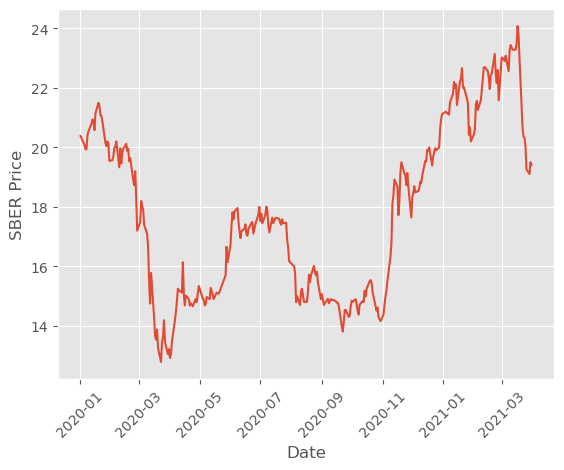

In [14]:
plt.ylabel('SBER Price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.plot(kchol_tur.index, kchol_tur['Price'])

**Extracting extra features from Date**

In [15]:
kchol_tur['month'] = kchol_tur.index.month
kchol_tur['day'] = kchol_tur.index.day
kchol_tur['week'] = kchol_tur.index.isocalendar().week
kchol_tur['day_of_week'] = kchol_tur.index.day_of_week

## Stationarity

In [16]:
kchol_tur

,Price,Open,High,Low,Vol.,Change %,month,day,week,day_of_week
Date,,,,,,,,,,
2020-01-02,20.38,20.42,20.44,20.24,2530000.0,0.0030,1,2,1,3
2020-01-03,20.30,20.30,20.44,19.97,3310000.0,-0.0039,1,3,1,4
2020-01-06,20.08,20.34,20.34,19.97,1940000.0,-0.0108,1,6,2,0
2020-01-07,19.93,20.22,20.28,19.92,2890000.0,-0.0075,1,7,2,1
2020-01-08,19.94,19.89,19.95,19.66,2790000.0,0.0005,1,8,2,2
...,...,...,...,...,...,...,...,...,...,...
2021-03-25,20.02,20.50,20.86,20.02,15930000.0,-0.0148,3,25,12,3
2021-03-26,19.25,20.28,20.36,19.10,21350000.0,-0.0385,3,26,12,4
2021-03-29,19.10,19.24,19.67,19.10,16560000.0,-0.0078,3,29,13,0


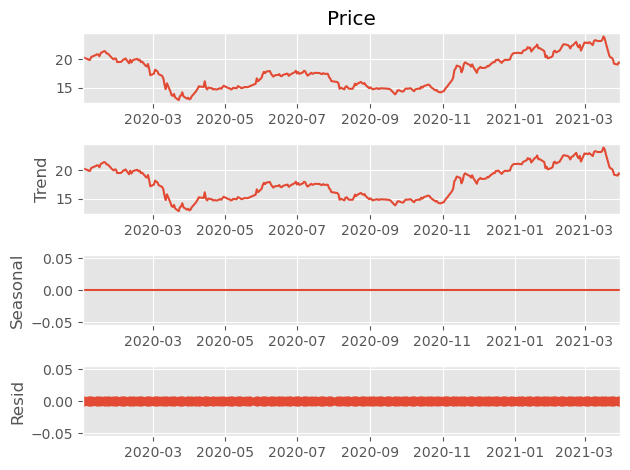

In [17]:
daily_decomposition = sm.tsa.seasonal_decompose(kchol_tur['Price'], model = 'additive', period = 1)

# Plot the original data, the trend, the seasonality, and the residuals 
_ = daily_decomposition.plot()
_ = plt.tight_layout()
_ = plt.show()

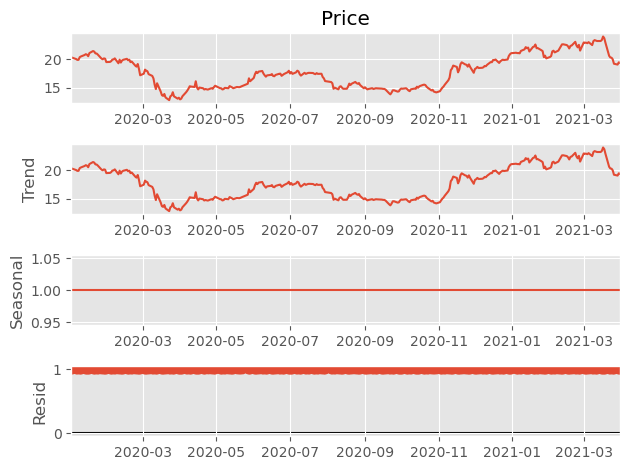

In [18]:
daily_decomposition = sm.tsa.seasonal_decompose(kchol_tur['Price'], model = 'multiplicative', period = 1)

# Plot the original data, the trend, the seasonality, and the residuals 
_ = daily_decomposition.plot()
_ = plt.tight_layout()
_ = plt.show()

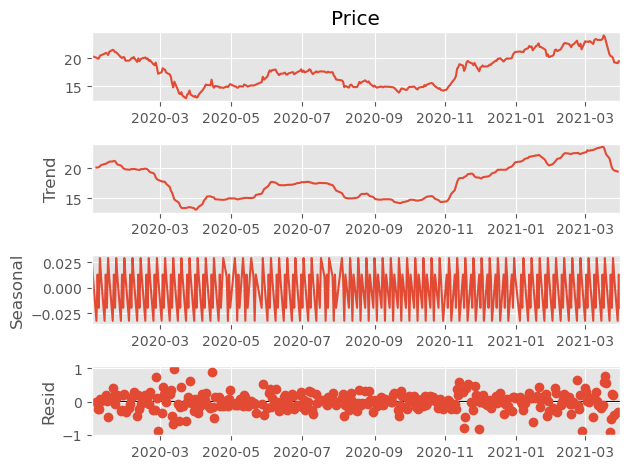

In [19]:
weekly_decomposition = sm.tsa.seasonal_decompose(kchol_tur['Price'], model = 'additive', period = 5)

# Plot the original data, the trend, the seasonality, and the residuals 
_ = weekly_decomposition.plot()
_ = plt.tight_layout()
_ = plt.show()

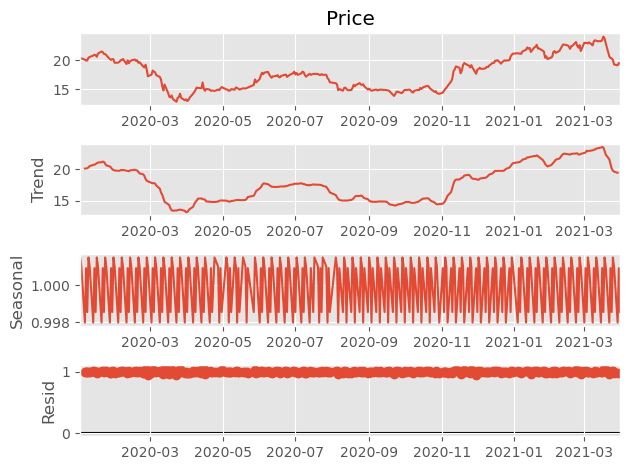

In [20]:
weekly_decomposition = sm.tsa.seasonal_decompose(kchol_tur['Price'], model = 'multiplicative', period = 5)

# Plot the original data, the trend, the seasonality, and the residuals 
_ = weekly_decomposition.plot()
_ = plt.tight_layout()
_ = plt.show()

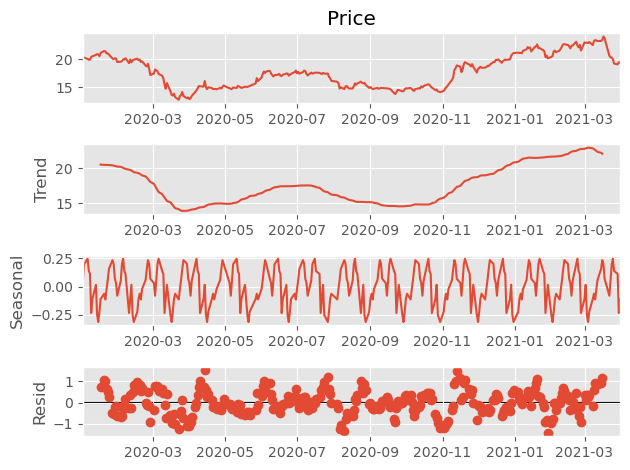

In [21]:
monthly_decomposition = sm.tsa.seasonal_decompose(kchol_tur['Price'], model = 'additive', period = 22)

# Plot the original data, the trend, the seasonality, and the residuals 
_ = monthly_decomposition.plot()
_ = plt.tight_layout()
_ = plt.show()

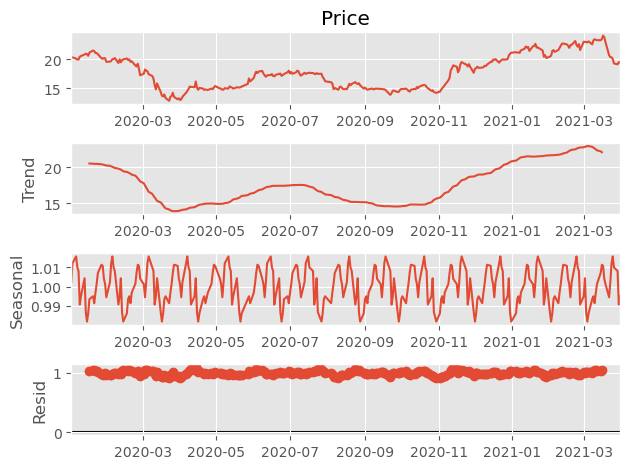

In [22]:
monthly_decomposition = sm.tsa.seasonal_decompose(kchol_tur['Price'], model = 'multiplicative', period = 22)

# Plot the original data, the trend, the seasonality, and the residuals 
_ = monthly_decomposition.plot()
_ = plt.tight_layout()
_ = plt.show()

**Dicky Fuller Test**

In [23]:
adf_res = adfuller(kchol_tur.Price.values, autolag= 'AIC')

In [24]:
print(f'p-value: {adf_res[0]}')

p-value: -1.4079062414294332


Since the p-value is less than 0.05, the time series is stationary

In [25]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

**KPSS**

In [26]:
kpss_test(kchol_tur.Price.values)

Results of KPSS Test:
Test Statistic            0.874128
p-value                   0.010000
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\ibane\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


As the p-value is less than 0.05, the null hypothesis is rejected and we can conclude that the time series is not stationary. 

**Detrending by differencing**

In [27]:
difference = kchol_tur.Price.diff()
kchol_tur['difference'] = difference
kchol_tur.dropna(inplace=True)

In [28]:
kchol_tur

,Price,Open,High,Low,Vol.,Change %,month,day,week,day_of_week,difference
Date,,,,,,,,,,,
2020-01-03,20.30,20.30,20.44,19.97,3310000.0,-0.0039,1,3,1,4,-0.08
2020-01-06,20.08,20.34,20.34,19.97,1940000.0,-0.0108,1,6,2,0,-0.22
2020-01-07,19.93,20.22,20.28,19.92,2890000.0,-0.0075,1,7,2,1,-0.15
2020-01-08,19.94,19.89,19.95,19.66,2790000.0,0.0005,1,8,2,2,0.01
2020-01-09,20.42,20.20,20.58,20.08,7940000.0,0.0241,1,9,2,3,0.48
...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,20.02,20.50,20.86,20.02,15930000.0,-0.0148,3,25,12,3,-0.30
2021-03-26,19.25,20.28,20.36,19.10,21350000.0,-0.0385,3,26,12,4,-0.77
2021-03-29,19.10,19.24,19.67,19.10,16560000.0,-0.0078,3,29,13,0,-0.15


In [29]:
print(adfuller(kchol_tur.difference.values, autolag= 'AIC')[0])

-7.401275237817392


In [30]:
kpss_test(kchol_tur.difference.values)

Results of KPSS Test:
Test Statistic           0.21461
p-value                  0.10000
Lags Used                2.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64


C:\Users\ibane\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Since the p-value is less than 0.05, the time series is now stationary. 

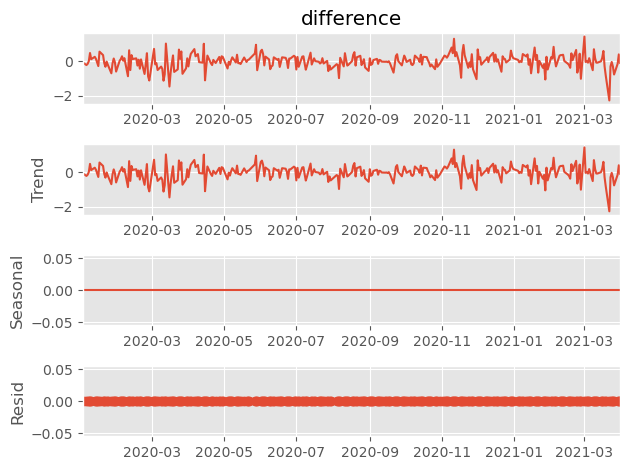

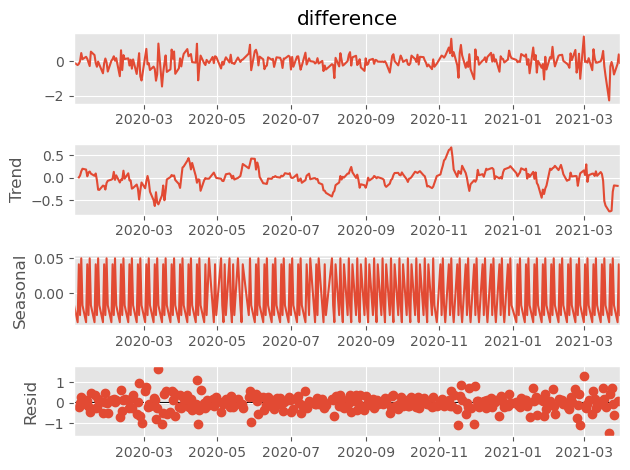

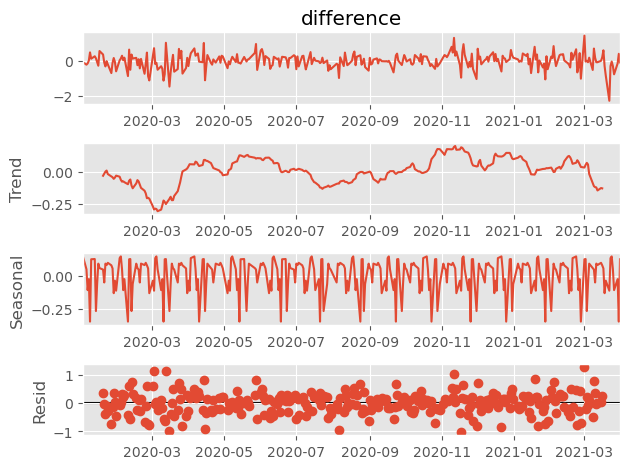

In [31]:
daily_decomposition = sm.tsa.seasonal_decompose(kchol_tur['difference'], model = 'additive', period = 1)
weekly_decomposition = sm.tsa.seasonal_decompose(kchol_tur['difference'], model = 'additive', period = 5)
monthly_decomposition = sm.tsa.seasonal_decompose(kchol_tur['difference'], model = 'additive', period = 22)

# Plot the original data, the trend, the seasonality, and the residuals 
_ = daily_decomposition.plot()
_ = weekly_decomposition.plot()
_ = monthly_decomposition.plot()
_ = plt.tight_layout()
_ = plt.show()

### Exogenous variables

In [32]:
#create rolling windows

In [33]:
lag_features = ['Open', 'High', 'Low', 'Vol.', 'Change %']
rolled_3d = kchol_tur[lag_features].rolling(window=3, min_periods=0)
rolled_7d = kchol_tur[lag_features].rolling(window=7, min_periods=0)
rolled_22d = kchol_tur[lag_features].rolling(window=22, min_periods=0)

In [34]:
#rolling means
kchol_tur_mean_3d = rolled_3d.mean().shift(1)
kchol_tur_mean_7d = rolled_7d.mean().shift(1)
kchol_tur_mean_22d = rolled_22d.mean().shift(1)

kchol_tur_mean_3d.fillna(kchol_tur_mean_3d.mean(), inplace=True)
kchol_tur_mean_7d.fillna(kchol_tur_mean_7d.mean(), inplace=True)
kchol_tur_mean_22d.fillna(kchol_tur_mean_22d.mean(), inplace=True)

kchol_tur_mean_3d.rename(columns = {'Open' : 'Open_3d_mean', 
                                    'High' : 'High_3d_mean', 
                                    'Low' : 'Low_3d_mean', 
                                    'Vol.' : 'Vol_3d_mean', 
                                    'Change %': 'Change_3d_mean'}, inplace=True)

kchol_tur_mean_7d.rename(columns = {'Open' : 'Open_7d_mean', 
                                    'High' : 'High_7d_mean', 
                                    'Low' : 'Low_7d_mean', 
                                    'Vol.' : 'Vol_7d_mean', 
                                    'Change %': 'Change_7d_mean'}, inplace=True)

kchol_tur_mean_22d.rename(columns = {'Open' : 'Open_22d_mean', 
                                    'High' : 'High_22d_mean', 
                                    'Low' : 'Low_22d_mean', 
                                    'Vol.' : 'Vol_22d_mean', 
                                    'Change %': 'Change_22d_mean'}, inplace=True)

In [35]:
df = pd.concat([kchol_tur, kchol_tur_mean_3d, kchol_tur_mean_7d,kchol_tur_mean_22d ], axis = 1)

In [36]:
#rolling standard dev
kchol_tur_std_3d = rolled_3d.std().shift(1)
kchol_tur_std_7d = rolled_7d.std().shift(1)
kchol_tur_std_22d = rolled_22d.std().shift(1)

kchol_tur_std_3d.fillna(kchol_tur_std_3d.mean(), inplace=True)
kchol_tur_std_7d.fillna(kchol_tur_std_7d.mean(), inplace=True)
kchol_tur_std_22d.fillna(kchol_tur_std_22d.mean(), inplace=True)

kchol_tur_std_3d.rename(columns = {'Open' : 'Open_3d_std', 
                                    'High' : 'High_3d_std', 
                                    'Low' : 'Low_3d_std', 
                                    'Vol.' : 'Vol_3d_std', 
                                    'Change %': 'Change_3d_std'}, inplace=True)

kchol_tur_std_7d.rename(columns = {'Open' : 'Open_7d_std', 
                                    'High' : 'High_7d_std', 
                                    'Low' : 'Low_7d_std', 
                                    'Vol.' : 'Vol_7d_std', 
                                    'Change %': 'Change_7d_std'}, inplace=True)

kchol_tur_std_22d.rename(columns = {'Open' : 'Open_22d_std', 
                                    'High' : 'High_22d_std', 
                                    'Low' : 'Low_22d_std', 
                                    'Vol.' : 'Vol_22d_std', 
                                    'Change %': 'Change_22d_std'}, inplace=True)

In [37]:
df = pd.concat([df, kchol_tur_std_3d, kchol_tur_std_7d, kchol_tur_std_22d ], axis = 1)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 314 entries, 2020-01-03 to 2021-03-31
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            314 non-null    float64
 1   Open             314 non-null    float64
 2   High             314 non-null    float64
 3   Low              314 non-null    float64
 4   Vol.             314 non-null    float64
 5   Change %         314 non-null    float64
 6   month            314 non-null    int32  
 7   day              314 non-null    int32  
 8   week             314 non-null    UInt32 
 9   day_of_week      314 non-null    int32  
 10  difference       314 non-null    float64
 11  Open_3d_mean     314 non-null    float64
 12  High_3d_mean     314 non-null    float64
 13  Low_3d_mean      314 non-null    float64
 14  Vol_3d_mean      314 non-null    float64
 15  Change_3d_mean   314 non-null    float64
 16  Open_7d_mean     314 non-null    float64
 1

In [39]:
df.describe()

,Price,Open,High,Low,Vol.,Change %,month,day,week,day_of_week,...,Open_7d_std,High_7d_std,Low_7d_std,Vol_7d_std,Change_7d_std,Open_22d_std,High_22d_std,Low_22d_std,Vol_22d_std,Change_22d_std
count,314.000000,314.000000,314.000000,314.000000,3.140000e+02,314.000000,314.000000,314.000000,314.0,314.000000,...,314.000000,314.000000,314.000000,3.140000e+02,314.000000,314.000000,314.000000,314.000000,3.140000e+02,314.000000
mean,17.849363,17.871306,18.138981,17.600287,1.111506e+07,0.000140,5.665605,15.675159,23.219745,1.990446,...,0.434691,0.426234,0.413452,3.821104e+06,0.021291,0.754940,0.754241,0.730863,4.706123e+06,0.022137
std,2.892491,2.878782,2.946217,2.851019,8.027290e+06,0.024236,3.629788,8.684544,15.993193,1.413051,...,0.306683,0.300006,0.296213,2.999099e+06,0.010215,0.457023,0.461916,0.460391,3.292421e+06,0.007781
min,12.790000,12.970000,13.110000,12.380000,1.920000e+06,-0.099400,1.000000,1.000000,1.0,0.000000,...,0.028284,0.048795,0.000000,4.176294e+05,0.003261,0.028284,0.070711,0.000000,5.743620e+05,0.003451
25%,15.005000,15.075000,15.212500,14.840000,5.727500e+06,-0.013375,2.000000,8.000000,9.0,1.000000,...,0.231649,0.231980,0.236839,1.955761e+06,0.013944,0.427060,0.409216,0.401874,2.427628e+06,0.016092
50%,17.580000,17.625000,17.855000,17.440000,8.765000e+06,0.000700,5.000000,16.000000,20.5,2.000000,...,0.381868,0.359962,0.340867,2.982356e+06,0.018240,0.642155,0.631999,0.616576,3.376107e+06,0.020692
75%,20.110000,20.175000,20.355000,19.957500,1.384000e+07,0.014975,9.000000,23.000000,37.0,3.000000,...,0.514075,0.509779,0.497769,4.565970e+06,0.026373,0.915109,0.915570,0.872661,6.522212e+06,0.025568
max,24.080000,24.380000,25.480000,23.480000,5.657000e+07,0.078000,12.000000,31.000000,53.0,4.000000,...,2.055497,1.991697,1.911216,1.619399e+07,0.056626,2.165116,2.115354,2.236342,1.382427e+07,0.044278


In [40]:
df.head(3)

,Price,Open,High,Low,Vol.,Change %,month,day,week,day_of_week,...,Open_7d_std,High_7d_std,Low_7d_std,Vol_7d_std,Change_7d_std,Open_22d_std,High_22d_std,Low_22d_std,Vol_22d_std,Change_22d_std
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,20.30,20.30,20.44,19.97,3310000.0,-0.0039,1,3,1,4,...,0.434691,0.426234,0.413452,3.821104e+06,0.021291,0.754940,0.754241,0.730863,4.706123e+06,0.022137
2020-01-06,20.08,20.34,20.34,19.97,1940000.0,-0.0108,1,6,2,0,...,0.434691,0.426234,0.413452,3.821104e+06,0.021291,0.754940,0.754241,0.730863,4.706123e+06,0.022137
2020-01-07,19.93,20.22,20.28,19.92,2890000.0,-0.0075,1,7,2,1,...,0.028284,0.070711,0.000000,9.687363e+05,0.004879,0.028284,0.070711,0.000000,9.687363e+05,0.004879


In [41]:
df.tail(3)

,Price,Open,High,Low,Vol.,Change %,month,day,week,day_of_week,...,Open_7d_std,High_7d_std,Low_7d_std,Vol_7d_std,Change_7d_std,Open_22d_std,High_22d_std,Low_22d_std,Vol_22d_std,Change_22d_std
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-29,19.10,19.24,19.67,19.10,16560000.0,-0.0078,3,29,13,0,...,1.964582,1.660591,1.807454,6.236116e+06,0.032841,1.360517,1.293941,1.426651,8.793911e+06,0.032127
2021-03-30,19.50,19.12,19.81,19.03,21050000.0,0.0209,3,30,13,1,...,1.563604,1.296282,1.426416,6.402330e+06,0.033327,1.520654,1.470223,1.561322,8.803936e+06,0.031607
2021-03-31,19.41,19.42,19.63,19.27,13140000.0,-0.0046,3,31,13,2,...,0.812134,0.660617,0.730913,5.353791e+06,0.038324,1.663192,1.602542,1.679731,8.920218e+06,0.030958


## EDA

In [42]:
kchol_tur_profile = ProfileReport(df, title = "SBER_2020", tsmode=True)

In [43]:
#kchol_tur_profile

## Train Test Split

In [44]:
train_kchol_tur = df['2020-01-01' : '2020-12-31']
test_kchol_tur = df['2021-01-01' : '2021-12-31']


In [45]:
X_train = train_kchol_tur.drop(['Price', 'difference'], axis = 1)
y_train = train_kchol_tur['difference']

X_test = test_kchol_tur.drop(['Price', 'difference'], axis = 1)
y_test = test_kchol_tur['difference']



## Simple Moving Average Models

In [46]:
def sma(data, n):
    sma = data.rolling(window = n).mean()
    return pd.DataFrame(sma)

n = [2, 5, 22]
for i in n:
    train_kchol_tur.loc[:, f'sma_{i}'] = sma(train_kchol_tur['Price'], i)

In [47]:
def implement_sma_strategy(data, short_window, long_window):
    sma1 = short_window
    sma2 = long_window
    buy_price = []
    sell_price = []
    sma_signal = []
    signal = 0
    
    for i in range(len(data)):
        if sma1[i] > sma2[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                sma_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                sma_signal.append(0)
        elif sma2[i] > sma1[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                sma_signal.append(-1)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                sma_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            sma_signal.append(0)
            
    return buy_price, sell_price, sma_signal

sma_2 = train_kchol_tur['sma_2']
sma_5 = train_kchol_tur['sma_5']
sma_22 = train_kchol_tur['sma_22']



In [48]:
train_kchol_tur.bfill(inplace = True)

In [49]:
train_kchol_tur

,Price,Open,High,Low,Vol.,Change %,month,day,week,day_of_week,...,Vol_7d_std,Change_7d_std,Open_22d_std,High_22d_std,Low_22d_std,Vol_22d_std,Change_22d_std,sma_2,sma_5,sma_22
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,20.30,20.30,20.44,19.97,3310000.0,-0.0039,1,3,1,4,...,3.821104e+06,0.021291,0.754940,0.754241,0.730863,4.706123e+06,0.022137,20.190,20.134,20.503636
2020-01-06,20.08,20.34,20.34,19.97,1940000.0,-0.0108,1,6,2,0,...,3.821104e+06,0.021291,0.754940,0.754241,0.730863,4.706123e+06,0.022137,20.190,20.134,20.503636
2020-01-07,19.93,20.22,20.28,19.92,2890000.0,-0.0075,1,7,2,1,...,9.687363e+05,0.004879,0.028284,0.070711,0.000000,9.687363e+05,0.004879,20.005,20.134,20.503636
2020-01-08,19.94,19.89,19.95,19.66,2790000.0,0.0005,1,8,2,2,...,7.018784e+05,0.003451,0.061101,0.080829,0.028868,7.018784e+05,0.003451,19.935,20.134,20.503636
2020-01-09,20.42,20.20,20.58,20.08,7940000.0,0.0241,1,9,2,3,...,5.743620e+05,0.004852,0.204512,0.212191,0.148549,5.743620e+05,0.004852,20.180,20.134,20.503636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,19.90,19.94,20.08,19.83,2940000.0,-0.0035,12,25,52,4,...,2.823271e+06,0.016408,0.617853,0.617267,0.662013,3.594517e+06,0.020605,19.935,19.756,19.132273
2020-12-28,20.00,19.92,20.12,19.92,4680000.0,0.0050,12,28,53,0,...,3.014569e+06,0.014764,0.647008,0.636947,0.695067,3.885016e+06,0.020185,19.950,19.878,19.171364
2020-12-29,20.62,20.04,20.66,20.00,9930000.0,0.0310,12,29,53,1,...,3.125449e+06,0.014868,0.669802,0.654799,0.726936,4.104595e+06,0.019747,20.310,20.066,19.259545


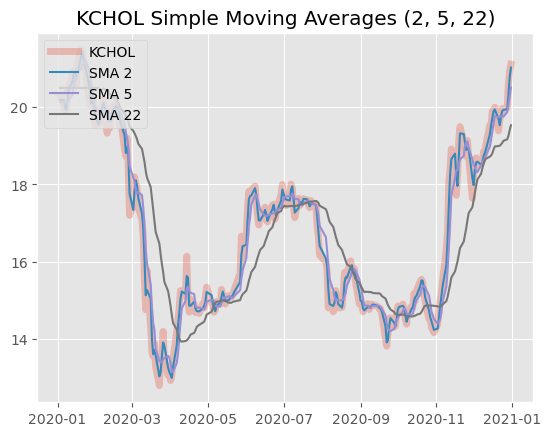

In [50]:
plt.plot(train_kchol_tur['Price'], label = 'KCHOL', linewidth = 5, alpha = 0.3)
plt.plot(train_kchol_tur['sma_2'], label = 'SMA 2')
plt.plot(train_kchol_tur['sma_5'], label = 'SMA 5')
plt.plot(train_kchol_tur['sma_22'], label = 'SMA 22')
plt.title('KCHOL Simple Moving Averages (2, 5, 22)')
plt.legend(loc = 'upper left')
plt.show()

C:\Users\ibane\AppData\Local\Temp\ipykernel_19476\1047753667.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sma1[i] > sma2[i]:
C:\Users\ibane\AppData\Local\Temp\ipykernel_19476\1047753667.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_price.append(data[i])
C:\Users\ibane\AppData\Local\Temp\ipykernel_19476\1047753667.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif sma2[i] > sma1[i]:
C:\Users\ibane\AppData

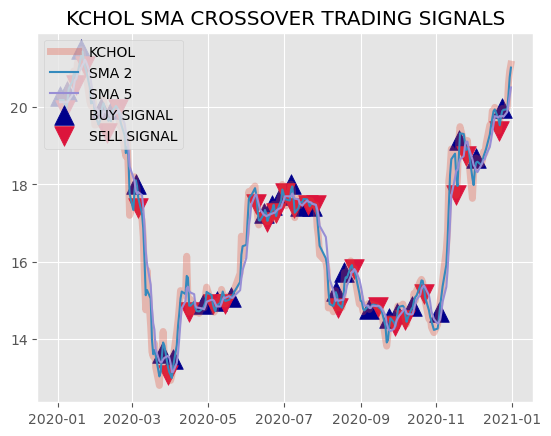

In [51]:
buy_price, sell_price, signal = implement_sma_strategy(train_kchol_tur['Price'], sma_2, sma_5)
plt.plot(train_kchol_tur['Price'], label = 'KCHOL', linewidth = 5, alpha = 0.3)
plt.plot(train_kchol_tur['sma_2'], label = 'SMA 2')
plt.plot(train_kchol_tur['sma_5'], label = 'SMA 5')
plt.scatter(train_kchol_tur.index, buy_price, marker = '^', s = 200, color = 'darkblue', label = 'BUY SIGNAL')
plt.scatter(train_kchol_tur.index, sell_price, marker = 'v', s = 200, color = 'crimson', label = 'SELL SIGNAL')
plt.legend(loc = 'upper left')
plt.title('KCHOL SMA CROSSOVER TRADING SIGNALS')
plt.show()

C:\Users\ibane\AppData\Local\Temp\ipykernel_19476\1047753667.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sma1[i] > sma2[i]:
C:\Users\ibane\AppData\Local\Temp\ipykernel_19476\1047753667.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif sma2[i] > sma1[i]:
C:\Users\ibane\AppData\Local\Temp\ipykernel_19476\1047753667.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sell_price.append(data[i])
C:\Users\ibane\AppDat

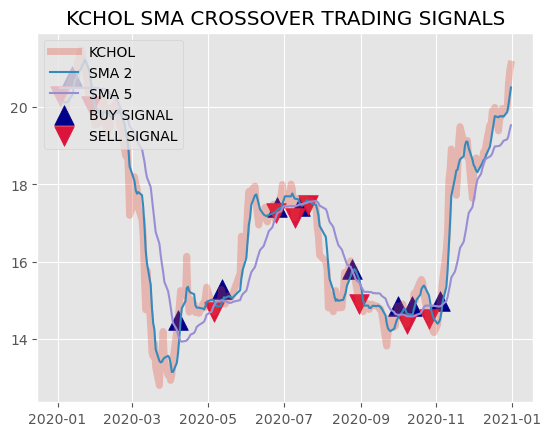

In [52]:
buy_price, sell_price, signal = implement_sma_strategy(train_kchol_tur['Price'], sma_2, sma_22)
plt.plot(train_kchol_tur['Price'], label = 'KCHOL', linewidth = 5, alpha = 0.3)
plt.plot(train_kchol_tur['sma_5'], label = 'SMA 2')
plt.plot(train_kchol_tur['sma_22'], label = 'SMA 5')
plt.scatter(train_kchol_tur.index, buy_price, marker = '^', s = 200, color = 'darkblue', label = 'BUY SIGNAL')
plt.scatter(train_kchol_tur.index, sell_price, marker = 'v', s = 200, color = 'crimson', label = 'SELL SIGNAL')
plt.legend(loc = 'upper left')
plt.title('KCHOL SMA CROSSOVER TRADING SIGNALS')
plt.show()

C:\Users\ibane\AppData\Local\Temp\ipykernel_19476\1047753667.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sma1[i] > sma2[i]:
C:\Users\ibane\AppData\Local\Temp\ipykernel_19476\1047753667.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif sma2[i] > sma1[i]:
C:\Users\ibane\AppData\Local\Temp\ipykernel_19476\1047753667.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sell_price.append(data[i])
C:\Users\ibane\AppDat

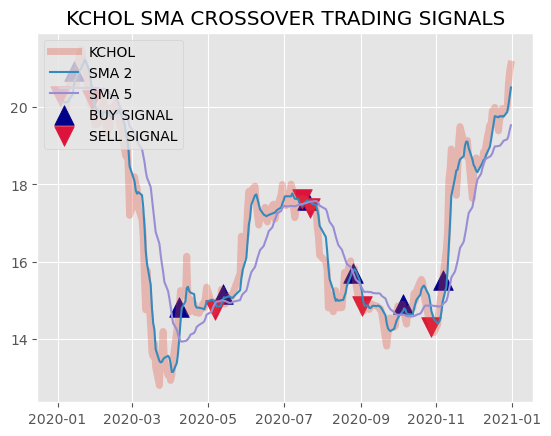

In [53]:
buy_price, sell_price, signal = implement_sma_strategy(train_kchol_tur['Price'], sma_5, sma_22)
plt.plot(train_kchol_tur['Price'], label = 'KCHOL', linewidth = 5, alpha = 0.3)
plt.plot(train_kchol_tur['sma_5'], label = 'SMA 2')
plt.plot(train_kchol_tur['sma_22'], label = 'SMA 5')
plt.scatter(train_kchol_tur.index, buy_price, marker = '^', s = 200, color = 'darkblue', label = 'BUY SIGNAL')
plt.scatter(train_kchol_tur.index, sell_price, marker = 'v', s = 200, color = 'crimson', label = 'SELL SIGNAL')
plt.legend(loc = 'upper left')
plt.title('KCHOL SMA CROSSOVER TRADING SIGNALS')
plt.show()

# Bollinger Bands

In [54]:
def bollinger_bands(df, n):
    # takes dataframe on input
    # n = smoothing length
    
    df['mov_avg'] = df['predicted'].rolling(n).mean()
    df['mov_std'] = df['predicted'].rolling(n).std()
    df['upper'] = df['mov_avg'] + 2*df['mov_std']
    df['lower'] = df['mov_avg'] - 2*df['mov_std']
    df.dropna(inplace = True)
    return df

def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

def plot_bollinger(df, buy_price, sell_price):
    df['predicted'].plot(label = 'Predicted Price', alpha = 0.3, color = 'blue')
    df['test_set'].plot(label = 'Actual Price', alpha = 0.3, color = 'red')
    df['upper'].plot(label = 'Upper BB', linestyle = '--', linewidth = 1, color = 'black')
    df['mov_avg'].plot(label = 'Middle BB', linestyle = '--', linewidth = 1.2, color = 'grey')
    df['lower'].plot(label = 'Lower BB', linestyle = '--', linewidth = 1, color = 'black')
    plt.scatter(df.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
    plt.scatter(df.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
    plt.title('Bollinger Band Strategy Trading Signals')
    plt.legend(loc = 'upper left')
    plt.show()

    
def calculate_return(buy_price, sell_price, y_test):
    i = 0
    result =0
    bp = None
    initial = None
    while i < len(buy_price) and math.isnan(buy_price[i]):
        i+=1
    if i < len(buy_price) and buy_price[i]>0:
        initial = buy_price[i]
    while i < len(buy_price):
        if buy_price[i]>0:
            bp = buy_price[i]
        elif sell_price[i]>0:
            if bp:
                result += (sell_price[i]-bp)
                bp = None
        i+=1
    if initial:
        result = (result/initial)*100
    do_nothing = (y_test[-1]/y_test[0] -1)*100
    print(f'Return using Bollinger Band Strategy is {round(result,2)}%.\nReturn from do nothing strategy is {round(do_nothing,2)}%')

# Functions for Eventual Model Evaluation and Visualisation

In [55]:
def actual_prediction_plot(actual, prediction, data_name, model_name):
    plt.figure(figsize=(16, 5))
    
    # Convert string dates to datetime objects
    start_date = datetime.strptime('1/1/2021', '%m/%d/%Y')
    end_date = datetime.strptime('4/1/2021', '%m/%d/%Y')

    # Set x-axis limits
    plt.xlim([mdates.date2num(start_date), mdates.date2num(end_date)])

    plt.plot(actual, label='Actual', linewidth=1.5)
    plt.plot(prediction, label='Predictions', linewidth=1.5)
    plt.title(f'Actual  VS. Predicted Price for {model_name}', fontsize=20)
    plt.legend();

    plt.show()


In [56]:
def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

## ARIMA Model

In [57]:
data_name = 'KCHOL TUR'
model_name = 'KCHOL ARIMA MODEL'

In [58]:

arima_model = pm.auto_arima(y_train, start_p=1, start_q=1, test='adf', max_p=6, max_q=6, 
                      m=1, d=None, seasonal=False, start_P=0, D=1, trace=False, error_action='ignore',  
                      suppress_warnings=True, stepwise=False)
y_pred = arima_model.predict(len(y_test)) 


C:\Users\ibane\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ibane\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


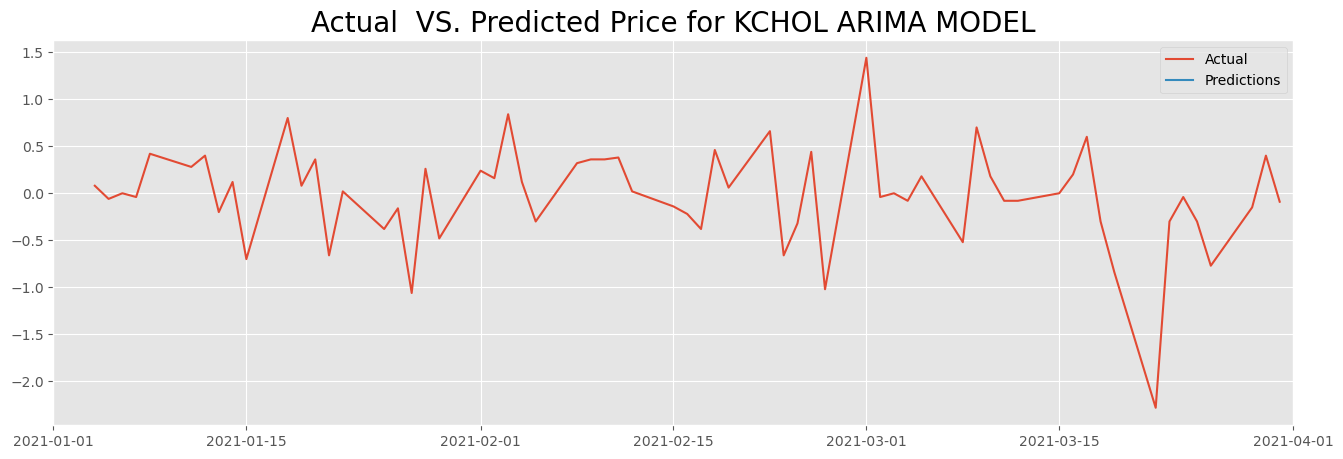

In [59]:
actual_prediction_plot(y_test, y_pred, data_name, model_name)

In [60]:
res = mae(y_test, y_pred)
print(res)

0.37516670419088843


## ARIMAX Model

In [61]:
data_name = 'KCHOL TUR'
model_name = "KCHOL TUR ARIMAX Model"

In [62]:

arimax_model = pm.auto_arima(y_train, exogenous=X_train, trace=False, error_action="ignore", 
                                 suppress_warnings=True)
arimax_model.fit(y_train, exogenous=X_train)
y_pred = arimax_model.predict(len(y_test)) 
predictions = pd.DataFrame(y_pred, index = y_test.index, columns = ['y_pred'])

C:\Users\ibane\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ibane\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


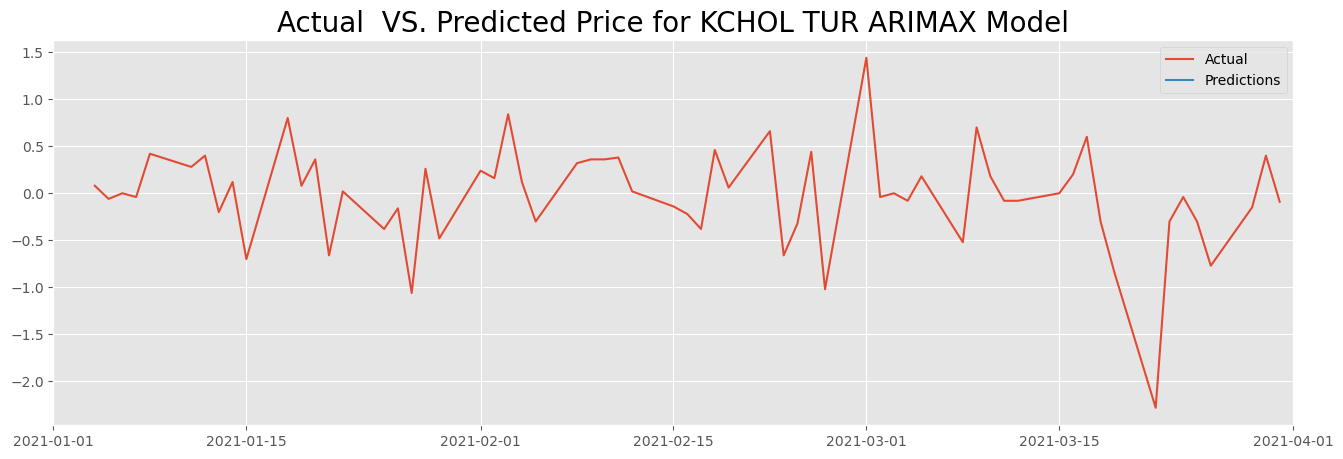

In [63]:
actual_prediction_plot(y_test, predictions['y_pred'], data_name, model_name)

In [64]:
res = mae(y_test, y_pred)
print(res)

0.37444444444444414


In [65]:
y_pred

251    0.0
252    0.0
253    0.0
254    0.0
255    0.0
      ... 
309    0.0
310    0.0
311    0.0
312    0.0
313    0.0
Length: 63, dtype: float64

## SARIMAX

C:\Users\ibane\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ibane\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


0.37526230091418145


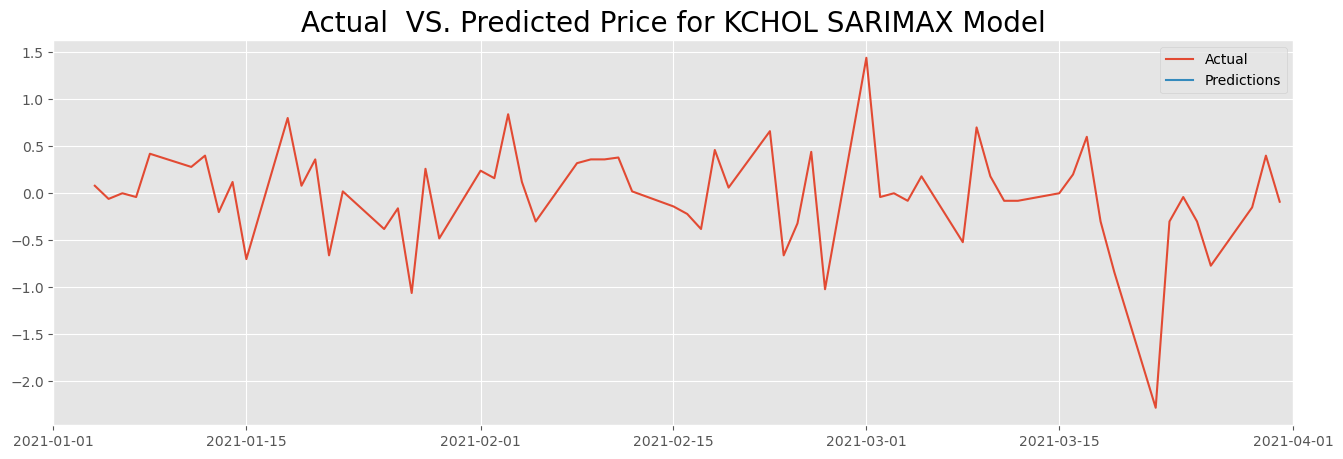

In [66]:
data_name = 'KCHOL TUR'
sarima_model = pm.auto_arima(y_train, start_p=1, start_q=1, test='adf', max_p=6, max_q=6, 
                  m=1, d=None, seasonal=True, start_P=0, D=1, trace=False, error_action='ignore',  
                  suppress_warnings=True, stepwise=False)
y_pred = sarima_model.predict(len(y_test))
model_name = "KCHOL SARIMAX Model"
    
res = mae(y_test, y_pred)
print(res)
actual_prediction_plot(y_test, y_pred, data_name, model_name)

## Univariate LSTM

In [67]:
data_name = 'KCHOL'
model_name = 'KCHOL Univariate LSTM'

In [68]:
df1 = df

In [69]:
lookback = 6 # number of days you want to use 
data_raw = df1.to_numpy()
data = []
for index in range(len(data_raw) - lookback):
    data.append(data_raw[index: index + lookback + 1])
data = np.array(data)

In [70]:
#the size of your reshaped array should be (314-6, 6*41)
X = data [:, :-1].reshape(len(data), lookback*df.shape[1])
y = data[:, -1, -1].reshape(-1,1) #y is a 2d array here
y = y.flatten()

In [71]:
df_featured = pd.DataFrame(X)
df_featured['y'] = y

In [72]:
df_featured.set_index(df1.index[lookback:], inplace = True)

In [73]:
df_featured.shape

(308, 247)

In [74]:
features = df_featured.drop(['y'], axis = 1)
target = df_featured[['y']]

In [75]:
print(features.head(3))
print(features.tail(3))

              0      1      2      3          4       5   6   7   8   9    \
Date                                                                        
2020-01-13   20.3   20.3  20.44  19.97  3310000.0 -0.0039   1   3   1   4   
2020-01-14  20.08  20.34  20.34  19.97  1940000.0 -0.0108   1   6   2   0   
2020-01-15  19.93  20.22  20.28  19.92  2890000.0 -0.0075   1   7   2   1   

            ...       236       237       238             239       240  \
Date        ...                                                           
2020-01-13  ...    0.1772  0.234989  0.156684  2381392.449807  0.013856   
2020-01-14  ...  0.213393  0.261719  0.197248  2144301.751154   0.01259   
2020-01-15  ...  0.220206  0.299611  0.267484  1971673.207734  0.012263   

                 241       242       243             244       245  
Date                                                                
2020-01-13    0.1772  0.234989  0.156684  2381392.449807  0.013856  
2020-01-14  0.213393  0.261719 

In [76]:
print(target.head(3))
print(target.tail(3))

                   y
Date                
2020-01-13   0.01259
2020-01-14  0.012263
2020-01-15  0.011428
                   y
Date                
2021-03-29  0.032127
2021-03-30  0.031607
2021-03-31  0.030958


In [79]:
univariate_X_train = features['2020-01-01' : '2020-12-31']
univariate_X_test = features['2021-01-01' : '2021-12-31']
univariate_X_val = univariate_X_train.iloc[196:]

univariate_y_train = target['2020-01-01' : '2020-12-31']
univariate_y_test = target['2021-01-01' : '2021-12-31']
univariate_y_val = univariate_y_train.iloc[196:]

In [80]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(lookback, univariate_X_train.shape[1]//lookback)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics = ['mae'])

# Reshape the features for the LSTM model
X_train = np.reshape(univariate_X_train.values, (univariate_X_train.shape[0], lookback, features.shape[1]//lookback))
X_train = X_train.astype('float32')
X_test = np.reshape(univariate_X_test.values, (univariate_X_test.shape[0], lookback, features.shape[1]//lookback))
X_test = X_test.astype('float32')
X_val = np.reshape(univariate_X_val.values, (univariate_X_val.shape[0], lookback, features.shape[1]//lookback))
X_val = X_val.astype('float32')
y_train = np.nan_to_num(univariate_y_train)
y_train = y_train.astype('float32')
y_test = np.nan_to_num(univariate_y_test)
y_test = y_test.astype('float32')
y_val = np.nan_to_num(univariate_y_val)
y_val = y_val.astype('float32')
# Fit the model
hist = model.fit(X_train, y_train, epochs=10, verbose=0, batch_size = 16, validation_data=(X_val, y_val))
predictions = model.predict(X_test)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test MAE:', mae)

2/2 [==============================] - 0s 7ms/step
Test loss: 89479299072.0
Test MAE: 222049.09375


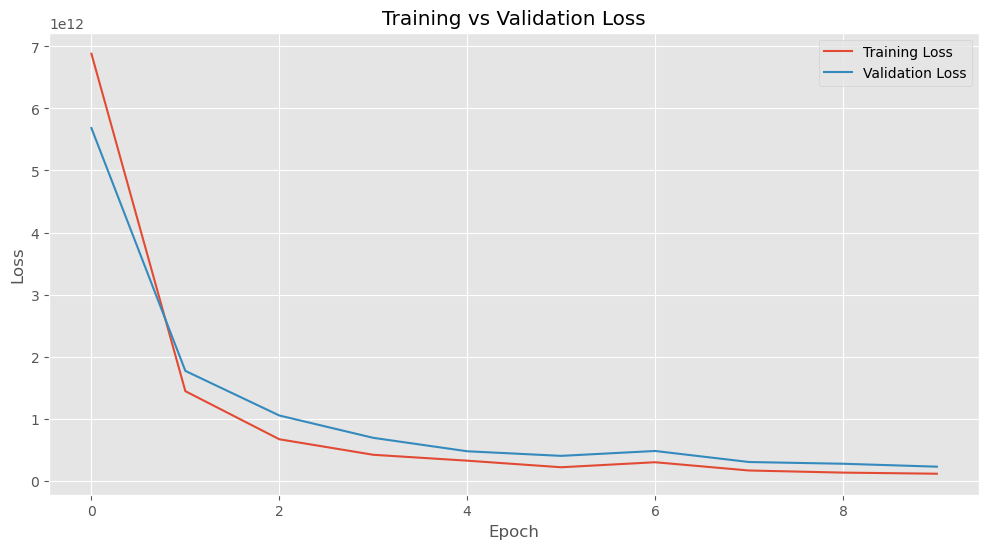

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Multivariate LSTM

In [83]:
data_name = 'KCHOL'
model_name = 'KCHOL multivariate LSTM'

In [84]:
df2 = df

In [85]:
multivariate_X_train = features['2020-01-01' : '2020-12-31']
multivariate_X_test = features['2021-01-01' : '2021-12-31']

multivariate_y_train = target['2020-01-01' : '2020-12-31']
multivariate_y_test = target['2021-01-01' : '2021-12-31']

In [86]:
lookback = 6

X_train, y_train = list(), list()
for i in range(len(multivariate_X_train)):
    # find the end of this pattern
    end_ix = i + lookback
    if end_ix > len(multivariate_X_train):
        break
        # gather input and output parts of the pattern
    seq_x = multivariate_X_train.iloc[i:end_ix, :]
    seq_y = multivariate_y_train.iloc[end_ix-1]
    X_train.append(seq_x)
    y_train.append(seq_y)
X_test, y_test = list(), list()
for i in range(len(multivariate_X_test)):
    # find the end of this pattern
    end_ix = i + lookback
    if end_ix > len(multivariate_X_test):
        break
        # gather input and output parts of the pattern
    seq_x = multivariate_X_test.iloc[i:end_ix, :]
    seq_y = multivariate_y_test.iloc[end_ix-1]
    X_test.append(seq_x)
    y_test.append(seq_y)


In [87]:
type(np.array(X_train))

numpy.ndarray

In [88]:
X_train = np.array(X_train)
X_test = np.array(X_test)


y_train = np.array(y_train)
y_test = np.array(y_test)


X_val = X_train[192:]
y_val = y_train[192:]

In [89]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(6, 5)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics = ['mae'])

# Reshape the features for the LSTM model
X_train = X_train[:, :, :5]
X_test = X_test[:, :, :5]
X_val = X_val[:, :, :5]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_val = X_val.astype('float32')
y_train = np.nan_to_num(y_train)
y_train = y_train.astype('float32')
y_test = np.nan_to_num(y_test)
y_test = y_test.astype('float32')
y_val = np.nan_to_num(y_val)
y_val = y_val.astype('float32')
# Fit the model
hist = model.fit(X_train, y_train, epochs=10, verbose=0, batch_size = 16, validation_data=(X_val, y_val))
predictions = model.predict(X_test)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test MAE:', mae)

2/2 [==============================] - 1s 11ms/step
Test loss: 85679726592.0
Test MAE: 173558.0


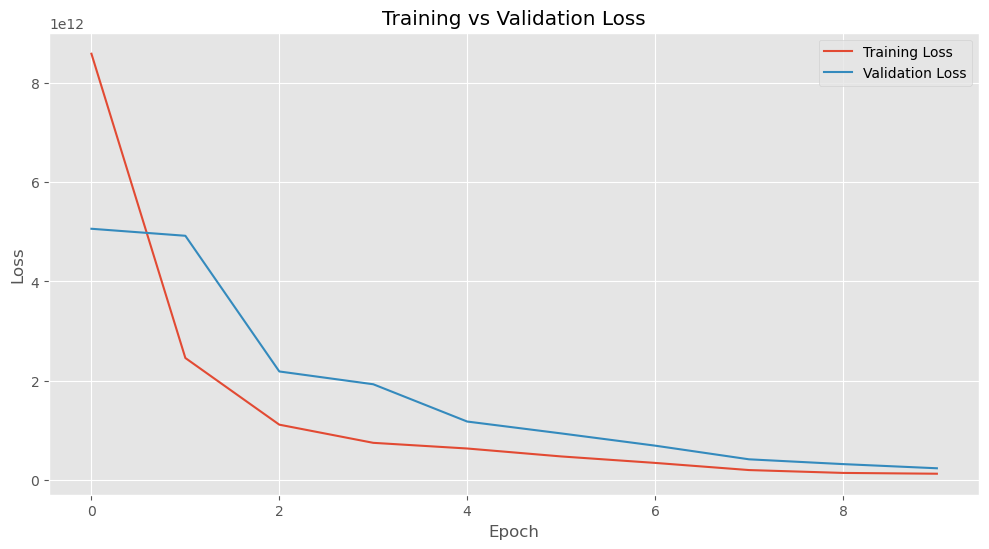

In [90]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()